# Conversation analysis with LLMs

We investigate the accuracy of LLMs in the task of finding the intent of an utterance in a conversation. This is a useful thing to do. According to Google Bard: 
> Conversational AI systems use intents to understand the user's goals and to generate responses that are relevant and helpful. By identifying the intent of a user's utterance, a conversational AI system can provide the user with the information or service that they need, or they can simply engage in a natural and engaging conversation.

The typical approach is to train a model for the specific use case, which requires significant training data. Here, chatGPT -3.5 and PaLM bison-001 are compared.

Sections:
- Query the LLM for intent and test that on a small set of movie dialogs.  It appears that chatGPT does better than PaLM.
- Use the dailydialog dataset from ConvoLab3 to quantify the performance of the LLMs. In this case we need to restrict the output to the intents specified in the dataset.
- Both LLMs show similar overall performance patterns, but PaLM does better than chatGPT in the test.


In [1]:
import os
import json
import re
import pandas as pd
import logging
import time
from datetime import datetime
import random
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import openai
import google.generativeai as palm
import google.generativeai.types.safety_types as safety_types

from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.llms.google_palm import GooglePalm
from langchain.chains import LLMChain

PALM_API_KEY = os.environ['PALM_API_KEY']

oMODEL = "gpt-3.5-turbo"
gMODEL = 'models/text-bison-001'

g_api_key = os.environ['PALM_API_KEY']
palm.configure(api_key=g_api_key)

BASEDIR = os.getcwd()
DATAFILE = os.path.join(BASEDIR, '../datasets/ConvLab/unified_datasets/dailydialog/data/dialogues.json')

RUNTIME = datetime.now().strftime('%y%m%d_%H:%m')

logging.basicConfig(filename=os.path.join(BASEDIR, f"run{RUNTIME}.log"), 
                    level=logging.INFO)

logging.info('Start log')

SAFETY = [
    {'category': safety_types.HarmCategory.HARM_CATEGORY_DEROGATORY,
     'threshold': safety_types.HarmBlockThreshold.BLOCK_NONE,
    },
    {'category': safety_types.HarmCategory.HARM_CATEGORY_TOXICITY,
     'threshold': safety_types.HarmBlockThreshold.BLOCK_NONE,
    },
    {'category': safety_types.HarmCategory.HARM_CATEGORY_VIOLENCE,
     'threshold': safety_types.HarmBlockThreshold.BLOCK_NONE,
    },
    {'category': safety_types.HarmCategory.HARM_CATEGORY_SEXUAL,
     'threshold': safety_types.HarmBlockThreshold.BLOCK_NONE,
    },
    {'category': safety_types.HarmCategory.HARM_CATEGORY_MEDICAL,
     'threshold': safety_types.HarmBlockThreshold.BLOCK_NONE,
    },
    {'category': safety_types.HarmCategory.HARM_CATEGORY_DANGEROUS,
     'threshold': safety_types.HarmBlockThreshold.BLOCK_NONE,
    },
]

LLM_OPENAI = OpenAI(temperature=0)
LLM_PALM = GooglePalm(google_api_key = PALM_API_KEY, 
                     max_output_tokens = 4096,
                     model_name='models/text-bison-001',
                     temperature=0.0,
                     verbose=True)

## Generating intents

We use a simple prompt to get the LLMs to generate intents for each turn in the conversation. We then use 3 short movie dialogs to illustrate the approach.

We use LangChain for chatGPT, but not for the PaLM because there seems to be a bug with some of the test data. 

In [ ]:
# ask the LLM for the intents in the turns 
anyIntent_template = """
What are the intent types of the turns in the following conversation? 

{dialog}
"""

anyIntentPrompt = PromptTemplate.from_template(anyIntent_template, variables=['dialog'])
anyIntentPalmChain = LLMChain(llm = LLM_PALM, prompt = anyIntentPrompt)
anyIntentOpenaiChain = LLMChain(llm = LLM_OPENAI, prompt = anyIntentPrompt)

In [134]:
testDialogs = []

testDialogs.append("""0. I didn’t put nothin’ up.
1. Yes, you did. You’ve been putting it up your whole life you just didn’t know it. You know what date is on this coin?
2. No.
3. 1958. It’s been traveling twenty-two years to get here. And now it’s here. And it’s either heads or tails. And you have to say. Call it.
4. Look, I need to know what I stand to win.
5. Everything.
""")

testDialogs.append("""0. C'mon, throw in a buck!
1. Uh-uh, I don't tip.
2. You don't tip?
3. No, I don't believe in it.
4. You don't believe in tipping?
5. You know what these chicks make? They make shit.
6. Don't give me that. She don't make enough money that she can quit.
""")

testDialogs.append("""0. We wants it, we needs it. Must have the precious. They stole it from us. Sneaky little hobbitses. Wicked, tricksy, false!
1. No. Not master!
2. Yes, precious, false! They will cheat you, hurt you, LIE.
3. Master is my friend.
4. You don’t have any friends; nobody likes you!
""")

def queryPalm(dialog):
    query = f"""What are the intent types of the turns in the following conversation? 

{dialog}
    """
    palmResp = palm.generate_text(
        model = gMODEL,
        prompt = query,
        temperature = 0,
        candidate_count = 1,
        safety_settings = SAFETY
    )
    print(palmResp.result)
    
for d in testDialogs:
    print(d)
    try:
        print('OpenAI')
        resp = anyIntentOpenaiChain({'dialog': d})
        print(resp['text'])
    except:
        print('Error in openai')
    try:
        print('\nPalm')
        resp = queryPalm(d)
        print(resp)
    except:
        print('Error in Palm')
    print('\n')

0. I didn’t put nothin’ up.
1. Yes, you did. You’ve been putting it up your whole life you just didn’t know it. You know what date is on this coin?
2. No.
3. 1958. It’s been traveling twenty-two years to get here. And now it’s here. And it’s either heads or tails. And you have to say. Call it.
4. Look, I need to know what I stand to win.
5. Everything.

OpenAI

0. Statement 
1. Explanation 
2. Question 
3. Explanation 
4. Request 
5. Exaggeration
Palm
0. statement
    1. statement
    2. statement
    3. statement
    4. question
    5. statement
None


0. C'mon, throw in a buck!
1. Uh-uh, I don't tip.
2. You don't tip?
3. No, I don't believe in it.
4. You don't believe in tipping?
5. You know what these chicks make? They make shit.
6. Don't give me that. She don't make enough money that she can quit.

OpenAI

0. Request 
1. Refusal 
2. Clarification 
3. Explanation 
4. Clarification 
5. Explanation 
6. Rebuttal
Palm
0. Request
    1. Refusal
    2. Question
    3. Statement
    4. Que

From the above, it seems that OpenAI has a richer set of intents and is perhaps more accurate than PaLM.

## Quantifying the performance

We next run the LLMs on a labeled dataset and compare the LLM output with the labels. In this case, the LLM will have to choose from a small set of labels.  We use the dailydialog dataset from ConvLab 3. This has only 4 intents: 'directive', 'commissive', 'question', 'inform'. These are a smaller set than the intents chatGPT comes up with.

It appears that chatGPT works better with a few-shot approach whereas PaLM does better with a zero-shot approach, so this is what we use for the tests.


In [2]:
# a few shot template that works well with chatGPT
openai_template = """You are an expert conversation analyst.
    
For each of the turns in the conversation below, determine the intent of the speaker. Each turn is prefixed by 'Turn' and should have exactly one intent.
Choose the intent from among {intents}. If none fit an utterance, mark it as 'unknown'. 
Format the intents as a comma-separated list. The number of intents must equal the number of turns in the conversation.

Examples:

Conversation:
<Turn 0>. Do you know the time?

<Turn 1>. It is noon.

<Turn 2>. I am going to lunch.

<Turn 3>. Wait for me.

Intents:
[question, inform, commissive, directive]

Conversation:
<Turn 0>. Don't forget to get a toothbrush.

<Turn 1>. I will not.

<Turn 2>. What color do you want?

<Turn 3>. Green.

Intents:
[directive, commissive, question, inform]


Conversation:
{dialog}

Intents:

"""

# this template works better with PaLM
palm_template = """
What are the intents of the turns in the following conversation? Choose between: {intents}

{dialog}

"""

openaiPrompt = PromptTemplate.from_template(openai_template, variables=['intents', 'dialog'])
palmPrompt = PromptTemplate.from_template(palm_template, variables=['intents', 'dialog'])

openaiChain = LLMChain(llm = LLM_OPENAI, prompt = openaiPrompt)
palmChain = LLMChain(llm = LLM_PALM, prompt = palmPrompt)

def queryLLM(dialogs: list[str], dlens: list[int], intents: list[str],
            llmName: str = 'openai', retries: int = 1):
    inputs = []
    for d in dialogs:
        inputs.append({'dialog': d, 'intents': intents})
    rets = 0
    isErr = False
    done = False
    while not done:
        if rets > 0:
            time.sleep(random.random())
            logging.info(f"Retry: {rets}")
        if rets >= retries:
            isErr = True
            logging.error('Cannot get result, exceeded retries')
            print('Cannot get result, exceeded retries')
            break
        intentList = []
        try:
            rets += 1
            if llmName == 'openai':
                response = CHAIN_OPENAI.apply(inputs)
            elif llmName == 'palm':
                response = CHAIN_PALM.apply(inputs)
            done = True
            logging.info('LLM response: ' + str(response))
            if len(response) != len(dlens):
                logging.error(f"number of responses: {len(response)}, number of dialogs: {len(dlens)}")
                print(f"number of responses: {len(response)}, number of dialogs: {len(dlens)}")
                done = False
                continue
            for i, resp in enumerate(response):
                logging.debug('RESPONSE ' + str(resp))
                if llmName == 'openai':
                    loi = [re.sub('\W+', '', x) for x in resp['text'].split(',')]
                else: 
                    loi = [re.sub('\d+\. ', '', x) for x in resp['text'].split('\n')]
                logging.debug('loi ' + str(loi))
                if len(loi) != dlens[i]:
                    logging.error(f"len of dialog: {dlens[i]}, len of response: {len(loi)}")
                    logging.error(inputs[i]['dialog'])
                    logging.error(str(resp))
                    print(f"len of dialog: {dlens[i]}, len of response: {len(loi)}")
                    done = False
                    break
                intentList.append(loi)
        except Exception as e:
            logging.error(f"Exception getting LLM response\n{str(e)}")
            print(f"Exception getting LLM response\n{str(e)}")
            done = False
    return intentList, isErr

    

We tried multiple formatting options for the dialogs, and again it appears that the format that works better for chatGPT is different from the one that works better with PaLM.

In [3]:
SEPARATE_TURNS = False      # double spacing
ADD_SPEAKER = False        # prefix with speaker:
ADD_TURN = False            # prefix with <Turn i>. 
ADD_INDEX = True          # prefix with i.
ALL_INTENTS = False
ANGLE_BRACKETS = False      # surround the utterance with <<...>>
JSON_REP = False
INTENTS_STRING = True

# for openai: separate_tuens, add_turn
# for palm: ADD_INDEX, ANGLE_BRACKETS

def getDialog(dialogStruct: dict, 
              separateTurns: bool = SEPARATE_TURNS,
              addSpeaker: bool = ADD_SPEAKER,
              addTurn: bool = ADD_TURN,
              addIndex: bool = ADD_INDEX,
              angleBrackets: bool = ANGLE_BRACKETS,
              jsonRep: bool = JSON_REP,
              intentsString: bool = INTENTS_STRING,
              allIntents: bool = ALL_INTENTS) -> (str, list[str]):
    """
    Params
      dialogStruct: dict ofr one dialog 
      addSpeaker: prefix the turns with the speaker
      addIndex: prefix the turns with the index
    Returns:
      dialog: the dialog
      intents: the true intents
    """
    dialog = ''
    intents = []
    did = dialogStruct['dialogue_id']
    for turn in dialogStruct['turns']:
        if not jsonRep:
            if addIndex: dialog += f"{turn['utt_idx']}. "
            elif addTurn: dialog += f"<Turn {turn['utt_idx']}>. "
            elif addSpeaker: dialog += f"{turn['speaker']}: "
            if angleBrackets: dialog += f"<<{turn['utterance']}>>\n"
            else: dialog += turn['utterance'] + '\n'
            if separateTurns: dialog += '\n'
        ti = []
        for ak in turn['dialogue_acts'].keys():
            atype = turn['dialogue_acts'][ak]
            for a in atype:
                if 'intent' in a and a['intent'] != '':
                    ti.append(a['intent'])
        if allIntents: intents.append(ti)
        elif len(ti) > 0: intents.append(ti[0])
        else: intents.append(None)
    nIntents = len(intents)
    if jsonRep:
        dialog = json.dumps([x['utterance'] for x in dialogStruct['turns']])
    if intentsString:
        intentList = intents
        intents = ','.join(intents)
    return dialog, intents, nIntents, did, intentList

def makeDialogGen(dataFname: str, batchSize: int = 1, numBatches: int = 5):
    batch = []
    lb = 0
    ub = lb + batchSize
    bcnt = 0
    with open(dataFname, 'r') as dx:
        dialogs = json.load(dx)
        nDialogs = len(dialogs)
        logging.info(f"Num dialogs: {nDialogs}")
        while lb < len(dialogs) and bcnt < numBatches:
            batch = [getDialog(x) for x in dialogs[lb: min(nDialogs, ub)]]
            yield batch
            lb += batchSize
            ub += batchSize
            bcnt += 1


def getIntents(llmType: str = 'palm',
               batchSize: int = 2,
               numBatches: int = 2,
               dataFile: str = DATAFILE,
               possIntents: list[str] = ['directive', 'commissive', 'question', 'inform'],
               maxErrors:int = 16,
              ):
    trues = []
    preds = []
    dialogIds = []
    dGen = makeDialogGen(dataFile, batchSize, numBatches)
    isErr = False
    nErr = 0
    nBatches = 0
    while True:
        if nErr >= maxErrors:
            logging.error('Quitting because of too many errors')
            print('Too many errors')
            break
        try:
            batch = next(dGen)   # list of [dialog, intents, nIntents, did], intentList
            nBatches += 1
        except StopIteration as e:
            break
        if nBatches % 100 == 0:
            print(f"{nBatches} batches")
        time.sleep(random.random())
        intents, dlens, dialogs, dids = [], [], [], []
        for x in batch:
            intents.append(x[4])
            dialogs.append(x[0])
            dids.append(x[2] * [x[3]])
            dlens.append(x[2])
        # dlens = [len(x) for x in intents]
        if llmType.lower() == 'openai':
            batchPreds, isErr = queryLLM(dialogs, dlens, possIntents, 'openai', retries=2)
        else:
            batchPreds, isErr = queryLLM(dialogs, dlens, possIntents, 'palm', retries=2)
        logging.debug('RESP: ' + str(batchPreds))
        if isErr: 
            nErr += 1
            logging.error(f"Num batch errors: {nErr}")
            print(f"Num batch errors: {nErr}")
            print(f"Num batches: {nBatches}. Error rate: {nErr/nBatches}")
        else:
            trues.extend(intents)
            preds.extend(batchPreds)
            dialogIds.extend(dids)
    return preds, trues, dialogIds, nErr

def evalLLMIntentions(llmType: str = 'palm',
               batchSize: int = 2,
               numBatches: int = 2,
               dataFile: str = DATAFILE,
               possIntents = ['directive', 'commissive', 'question', 'inform'],
               resultFname = None, # is gnerally done based on parameters.
               maxErrors: int = 16,
              ):
    if resultFname is None:
        resultFname = f"{llmType}_{batchSize}_{numBatches}_{datetime.now().strftime('%y%m%d_%H:%m')}.csv"
    preds, trues, dialogIds, nErr = getIntents(llmType = llmType,
                                        batchSize = batchSize,
                                        numBatches = numBatches,
                                        dataFile = dataFile,
                                        possIntents = possIntents,
                                        maxErrors = maxErrors)
    allPreds = list(chain(*preds))
    allTrues = list(chain(*trues))
    allIds = list(chain(*dialogIds))
    print(f"Total errors: {nErr}")
    rdf = pd.DataFrame(data={'preds': allPreds, 'trues': allTrues, 'ids': allIds})
    rdf.to_csv(resultFname, index=False)
    computeMetrics(rdf, resultFname.replace('.csv', '_cm.png'), possIntents)

def computeMetrics(df, cmFname, possIntents):
    allTrues = df['trues']
    allPreds = df['preds']
    p, r, f, s = precision_recall_fscore_support(allTrues, allPreds, labels=possIntents,
                                                 average=None, zero_division=np.nan)
    prf = np.array([p, r, f])
    print(f"Total utterances: {len(allTrues)}")
    print('Precision, recall, F1 for ' + ', '.join(possIntents))
    print(prf)
    cm = confusion_matrix(allTrues, allPreds, labels=possIntents)
    print('Confusion matrix for ' + ', '.join(possIntents))
    print(cm)
    cmDisp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = possIntents)
    cmDisp.plot()
    plt.savefig(cmFname)
    plt.show()

These are the results of running 1000 tests using chatGPT as model.

Total utterances: 5001
Precision, recall, F1 for directive, commissive, question, inform
[[0.29359823 0.18552036 0.72996058 0.8372093 ]
 [0.29424779 0.4969697  0.79870597 0.62376238]
 [0.29392265 0.27018122 0.7627875  0.71489362]]
Confusion matrix for directive, commissive, question, inform
[[ 133  104  134   81]
 [  59  164   21   83]
 [  44   53 1111  179]
 [ 217  563  256 1764]]


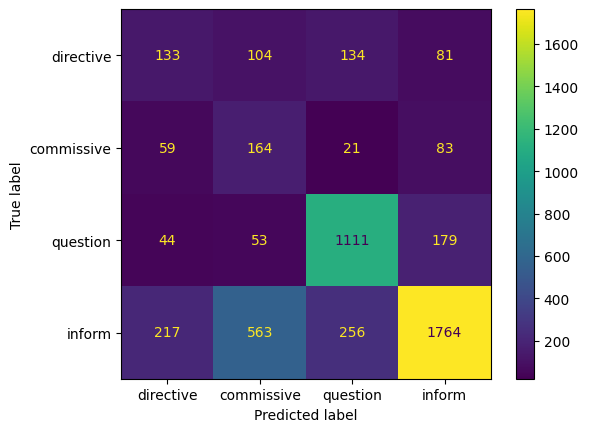

In [17]:
df = pd.read_csv(os.path.join(BASEDIR, 'openai_1000.csv'), index_col=None)
possIntents = ['directive', 'commissive', 'question', 'inform']
computeMetrics(df, '/tmp/openai.png', possIntents)

Total utterances: 7079
Precision, recall, F1 for directive, commissive, question, inform
[[0.45927904 0.257      0.86700508 0.86706853]
 [0.5375     0.5660793  0.81683405 0.701849  ]
 [0.49532037 0.35350757 0.84117213 0.7757593 ]]
Confusion matrix for directive, commissive, question, inform
[[ 344  125   67   99]
 [  42  257   30  114]
 [ 115   43 1708  206]
 [ 248  575  165 2733]]


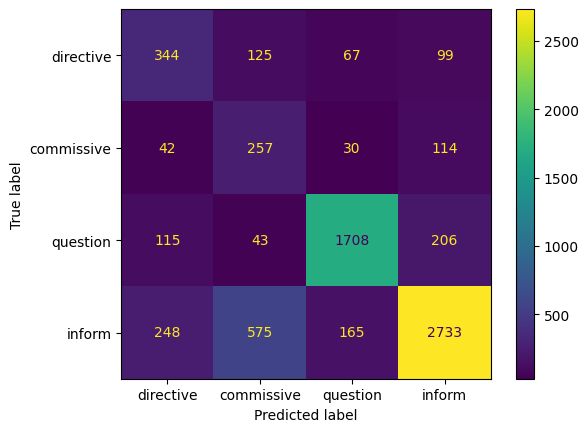

In [4]:
df = pd.read_csv(os.path.join(BASEDIR, 'palmRun.csv'), index_col=None)
possIntents = ['directive', 'commissive', 'question', 'inform']
computeMetrics(df, '/tmp/palm.png', possIntents)

# Results
- Palm does better than chatGPT on this test
- Both show a similar pattern of errors

This approach does not give good enough results for that dataset, however, the performance is likely to be improced with more tweaking.